In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./scandi.csv", usecols=range(12), header=None)
cc = pd.read_csv("./scandi.csv", usecols=[14], header=None)

In [3]:
df = df.join(cc)

In [4]:
df.drop([1, 9], axis=1, inplace=True)

In [5]:
df.iloc[:, -1].value_counts()

14
@1      124593
XT       49458
UT|C      8408
UT|O      3135
XT|C      1438
XT|O       324
OTC        320
M           22
UT|H         1
Name: count, dtype: int64

In [6]:
df.columns = ['Stock identifier', 'Bid Price', 'Ask Price', 'Trade Price', 'Bid Volume',
               'Ask Volume', 'Trade Volume', 'Update type', 'Date', 'Time in seconds past midnight',
               'Condition codes']

In [7]:
df_selected = df[df['Condition codes'].isnull()  | df['Condition codes'].isin(['@1', 'XT'])]

In [8]:
df_selected.head()

,Stock identifier,Bid Price,Ask Price,Trade Price,Bid Volume,Ask Volume,Trade Volume,Update type,Date,Time in seconds past midnight,Condition codes
0,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420,28264.0,@1
1,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420,28265.0,@1
2,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420,28266.0,@1
3,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420,28267.0,@1
4,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420,28268.0,@1


In [9]:
dates = df_selected['Date'].apply(str)

In [10]:
dates = pd.to_datetime(dates)

In [11]:
import datetime
times = df_selected['Time in seconds past midnight'].apply(lambda x: datetime.timedelta(seconds=x))

In [12]:
df_selected.index = dates + times

In [13]:
df_selected = df_selected.drop(['Time in seconds past midnight', 'Condition codes'], axis=1)

In [14]:
df_selected.head()

,Stock identifier,Bid Price,Ask Price,Trade Price,Bid Volume,Ask Volume,Trade Volume,Update type,Date
2015-04-20 07:51:04,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420
2015-04-20 07:51:05,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420
2015-04-20 07:51:06,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420
2015-04-20 07:51:07,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420
2015-04-20 07:51:08,BBHBEAT Index,121.4,125.4,123.4,1234,1234,1234,2,20150420


In [15]:
grouped = df_selected.groupby('Stock identifier')

In [16]:
for stock, df in grouped:
    print(f'For the stock {stock}, we have {len(df)} data')

For the stock ABB SS Equity, we have 184194 data
For the stock AKA NO Equity, we have 20931 data
For the stock AKSO NO Equity, we have 53439 data
For the stock ALFA SS Equity, we have 145090 data
For the stock AMEAS FH Equity, we have 61829 data
For the stock ASSAB SS Equity, we have 107227 data
For the stock ATCOA SS Equity, we have 222007 data
For the stock ATCOB SS Equity, we have 111276 data
For the stock AZN SS Equity, we have 267650 data
For the stock BBHBEAT Index, we have 124593 data
For the stock BOL SS Equity, we have 175805 data
For the stock BWLPG NO Equity, we have 26941 data
For the stock CARLB DC Equity, we have 76237 data
For the stock CGCBV FH Equity, we have 59605 data
For the stock CHR DC Equity, we have 76430 data
For the stock COLOB DC Equity, we have 64462 data
For the stock DANSKE DC Equity, we have 142439 data
For the stock DETNOR NO Equity, we have 42495 data
For the stock DNB NO Equity, we have 154020 data
For the stock DNO NO Equity, we have 82540 data
For th

In [17]:
df_selected.iloc[:, :-1].isna().sum() #no missing values

Stock identifier    0
Bid Price           0
Ask Price           0
Trade Price         0
Bid Volume          0
Ask Volume          0
Trade Volume        0
Update type         0
dtype: int64

In [18]:
df_selected['Update type'].value_counts()
#there are values not mentioned in the statement of the problem, after checking the data, 
#I suppose 8 means no change and 0 means the initial states(0 bid and zero ask)

Update type
2    5983019
3    5692093
1    1516407
8      54714
0        396
Name: count, dtype: int64

In [19]:
trading_time_avg = {}
trading_time_med = {}
trading_max_time = {}
stock_not_liquid = []

for stock, df in grouped:
    df = df[df['Update type'] == 1].sort_index()
    if len(df) == 0:
        stock_not_liquid.append(stock)
    else:
        diff_trade = df.reset_index().groupby('Date')['index'].apply(lambda x:x.diff()).dropna()
        trading_max_time[stock] = np.max(diff_trade).total_seconds()
        trading_time_avg[stock] = np.mean(diff_trade).total_seconds()
        trading_time_med[stock] = diff_trade.median().total_seconds()

In [20]:
trading_max_time = pd.Series(trading_max_time)
trading_time_avg = pd.Series(trading_time_avg)
trading_time_med = pd.Series(trading_time_med)

In [21]:
tick_time_avg = {}
tick_time_med = {}
tick_max_time = {}

for stock, df in grouped:
    df = df[df['Update type'] == 1].sort_index().reset_index()
    if len(df) > 0:
        tick_diff = df.groupby('Date')['Trade Price'].diff().fillna(0)
        idx = tick_diff != 0
        time_diff = df[['index', 'Date']][idx].groupby('Date')['index'].diff().dropna()
        tick_time_avg[stock] = np.mean(time_diff).total_seconds()
        tick_time_med[stock] = time_diff.median().total_seconds()
        tick_max_time[stock] = np.max(time_diff).total_seconds()

In [22]:
tick_time_avg = pd.Series(tick_time_avg)
tick_max_time = pd.Series(tick_max_time)
tick_time_med = pd.Series(tick_time_med)

In [23]:
spread_bid_ask_avg = {}
spread_bid_ask_med = {}

for stock, df in grouped:
    spread = df['Ask Price'] - df['Bid Price']
    spread_bid_ask_avg[stock] = np.mean(spread)
    spread_bid_ask_med[stock] = np.median(spread)

In [24]:
spread_bid_ask_avg = pd.Series(spread_bid_ask_avg)
spread_bid_ask_med = pd.Series(spread_bid_ask_med)

In [25]:
digit_prx_trade = {}
digit_vol_trade = {}
for stock, df in grouped:
    if stock not in stock_not_liquid:
        vol_trade_num = df['Trade Volume'].map(lambda x:str(x)[-1])
        prx_trade_num = df['Trade Price'].map(lambda x:str(x)[-1])
        if (vol_trade_num == '0').any():
            digit_vol_trade[stock] = vol_trade_num.value_counts().rank(ascending=False).loc['0']
            
        else:
            digit_vol_trade[stock] = vol_trade_num.nunique() + 1
            

        if (prx_trade_num == '0').any():
            digit_prx_trade[stock] = prx_trade_num.value_counts().rank(ascending=False).loc['0']
        else:
            digit_prx_trade[stock] = prx_trade_num.nunique() + 1

In [26]:
digit_vol_trade = pd.Series(digit_vol_trade)
digit_prx_trade = pd.Series(digit_prx_trade)

In [27]:
digit_prx_trade_freq = {}
digit_vol_trade_freq = {}
for stock, df in grouped:
    if stock not in stock_not_liquid:
        vol_trade_num = df['Trade Volume'].map(lambda x:str(x)[-1])
        prx_trade_num = df['Trade Price'].map(lambda x:str(x)[-1])
        if (vol_trade_num == '0').any():
            digit_vol_trade_freq[stock] = vol_trade_num.value_counts().loc['0'] / len(df)
        else:
            digit_vol_trade_freq[stock] = 0
            

        if (prx_trade_num == '0').any():
            digit_prx_trade_freq[stock] = prx_trade_num.value_counts().loc['0'] / len(df)
        else:
            digit_prx_trade_freq[stock] = 0

In [28]:
digit_vol_trade_freq = pd.Series(digit_vol_trade_freq)
digit_prx_trade_freq = pd.Series(digit_prx_trade_freq)

In [29]:
sum(digit_prx_trade_freq > 0.1) / len(digit_prx_trade_freq)

0.48484848484848486

In [30]:
sum(digit_vol_trade_freq > 0.1) / len(digit_vol_trade_freq)

0.9696969696969697

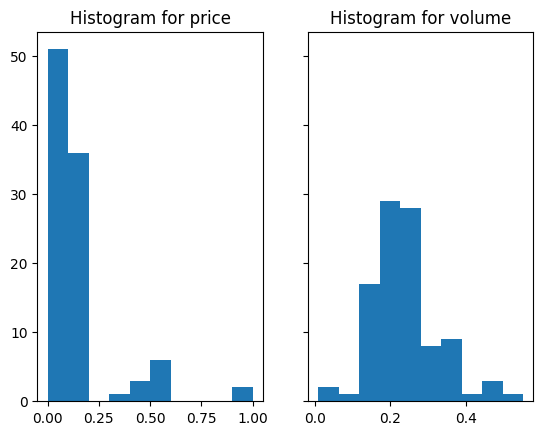

In [52]:
fig, ax = plt.subplots(1, 2, sharey=1)
ax[0].hist(digit_prx_trade_freq, label='Trade price')
ax[0].set_title('Histogram for price')
ax[1].hist(digit_vol_trade_freq, label='Trade volume')
ax[1].set_title('Histogram for volume')
fig.savefig("Frequency.png")


In [32]:
import statsmodels.api as sm

In [33]:
#Conduct hypothesis test for each stock
#null is the proportion should be 1/10, the alternativa is larger, which is indicated by the parameter alternative
prx_test_res = {}
vol_test_res = {}

for stock, df in grouped:
    if stock not in stock_not_liquid:
        vol_trade_num = df['Trade Volume'].map(lambda x: str(x)[-1])
        prx_trade_num = df['Trade Price'].map(lambda x: str(x)[-1])
        
        success_vol = (vol_trade_num == '0').sum()
        
        success_prx = (prx_trade_num == '0').sum()

        _, p_score_vol = sm.stats.proportions_ztest(success_vol, len(df), 0.1, alternative='larger')
        _, p_score_prx = sm.stats.proportions_ztest(success_prx, len(df), 0.1, alternative='larger')

        prx_test_res[stock] = p_score_prx < 0.05  # True if we reject H0

        vol_test_res[stock] = p_score_vol < 0.05  # True if we reject H0


c:\Users\kaihu\Desktop\market_pre\venv\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [34]:
vol_test_res = pd.Series(vol_test_res)
prx_test_res = pd.Series(prx_test_res)

In [36]:
final_df = pd.concat([trading_time_avg, trading_time_med, trading_max_time, 
                      tick_time_avg, tick_max_time,tick_time_med,
                      spread_bid_ask_avg, spread_bid_ask_med,
                      digit_vol_trade_freq, digit_prx_trade_freq,
                      vol_test_res, prx_test_res], axis=1)

In [38]:
final_df.columns = ['trading_time_avg', 'trading_time_med', 'trading_max_time', 
                    'tick_time_avg', 'tick_max_time', 'tick_time_med',
                    'spread_bid_ask_avg', 'spread_bid_ask_med',
                    'last_digit_vol_trade_freq', 'last_digit_prx_trade_freq',
                    'vol_test_res', 'prx_test_res']

In [40]:
final_df.to_csv('resultData.csv')